In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Wczytywanie danych i wstępne przetworzenie

In [8]:
df = pd.read_csv(r"C:\Users\aczac\Desktop\studia\analiza\analiza\tripadvisor_hotel_reviews.csv")

reviews = df['Review'].to_list()
y = (df['Rating'] >= 4).to_numpy()

In [ ]:
print(f'Łącznie próbek: {y.shape[0]}')
n_pos = (y == True).sum()
print(f'Pozytywne: {n_pos} ({n_pos / y.shape[0] * 100:0.2f}%)')
n_neg = (y == False).sum()
print(f'Negatywne: {n_neg} ({n_neg / y.shape[0] * 100:0.2f}%)')

Łącznie próbek: 20491
Pozytywne: 15093 (73.66%)
Negatywne: 5398 (26.34%)


# CountVectorizer (ekstrakcja cech)

In [16]:
cv = CountVectorizer(input='content',
                     strip_accents='ascii',
                     lowercase=True,
                     max_df=0.95,
                     min_df=0.001,
                     binary=True)
cv.fit(reviews)
X = cv.transform(reviews)

In [29]:
print(f'Rozmiar macierzy gdyby nie była rzadka: {(X.shape[0] * X.shape[1] * 64) / 8 / 1024 / 1024:0.2f} MB')
print(f'Wypełnienie macierzy: {X.size / (X.shape[0] * X.shape[1]) * 100:0.2f}%')
print(f'Rozmiar macierzy aktualnie: {(X.size * 64) / 8 / 1024 / 1024:0.2f} MB')

Rozmiar macierzy gdyby nie była rzadka: 999.91 MB
Wypełnienie macierzy: 1.20%
Rozmiar macierzy aktualnie: 12.00 MB


# Naive Bayes + CountVectorizer z użycie pipeline

In [60]:
clf = make_pipeline(CountVectorizer(input='content',
                                    strip_accents='ascii',
                                    lowercase=True,
                                    max_df=0.95,
                                    min_df=0.001,
                                    binary=True),
                    MultinomialNB(fit_prior=True))

In [61]:
rev_train, rev_test, y_train, y_test = train_test_split(reviews, y, test_size=0.2, random_state=0)

In [62]:
clf.fit(rev_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, max_df=0.95, min_df=0.001,
                                 strip_accents='ascii')),
                ('multinomialnb', MultinomialNB())])

In [63]:
y_pred_train = clf.predict(rev_train)
y_pred_test = clf.predict(rev_test)

print(f'Dokładność na danych uczących: {accuracy_score(y_train, y_pred_train) * 100:0.0f}%')
print(f'Dokładność na danych testowych: {accuracy_score(y_test, y_pred_test) * 100:0.0f}%')

Dokładność na danych uczących: 89%
Dokładność na danych testowych: 86%


In [64]:
students = [
    'Hotel schludny i dobrze wyposażony. Miła obsługa, śniadania smaczne i ładnie podane.',
    'Hotel neat and well equipped. Nice staff, breakfasts tasty and nicely served.',
    'Good location, clean rooms, tasty breakfast. I recommend!',
    "This was very very very disappointment visit. Hotel was dirty and did not reflected what I booked on internet. I highly don't recommended it. 2",
    'The room is neat and tidy, well equiped. The staff is kind and helpful. Breakfast tasty and well served'
    "The hotel was well-equipped and its location was breathtaking. Staff was extremely helpful and nice! this place is worth the hype, I totally recommend. ",
    "I've stayed in better hotels.",
    "Not bad.",
    "the hotel was partially equiped. The room was average. the Staff was focused more on the internal discussions instead of the customers"
]

for r in students:
    ans = clf.predict([r])[0]
    p_neg, p_pos = clf.predict_proba([r])[0]
    print(f'Opinia: "{r}"\njest {"pozytywna" if ans else "negatywna"} (P(+) = {p_pos:0.2f}, P(-) = {p_neg:0.2f})\n')

Opinia: "Hotel schludny i dobrze wyposażony. Miła obsługa, śniadania smaczne i ładnie podane."
jest pozytywna (P(+) = 0.77, P(-) = 0.23)

Opinia: "Hotel neat and well equipped. Nice staff, breakfasts tasty and nicely served."
jest pozytywna (P(+) = 1.00, P(-) = 0.00)

Opinia: "Good location, clean rooms, tasty breakfast. I recommend!"
jest pozytywna (P(+) = 0.98, P(-) = 0.02)

Opinia: "This was very very very disappointment visit. Hotel was dirty and did not reflected what I booked on internet. I highly don't recommended it. 2"
jest negatywna (P(+) = 0.29, P(-) = 0.71)

Opinia: "The room is neat and tidy, well equiped. The staff is kind and helpful. Breakfast tasty and well servedThe hotel was well-equipped and its location was breathtaking. Staff was extremely helpful and nice! this place is worth the hype, I totally recommend. "
jest pozytywna (P(+) = 1.00, P(-) = 0.00)

Opinia: "I've stayed in better hotels."
jest pozytywna (P(+) = 0.71, P(-) = 0.29)

Opinia: "Not bad."
jest negatyw

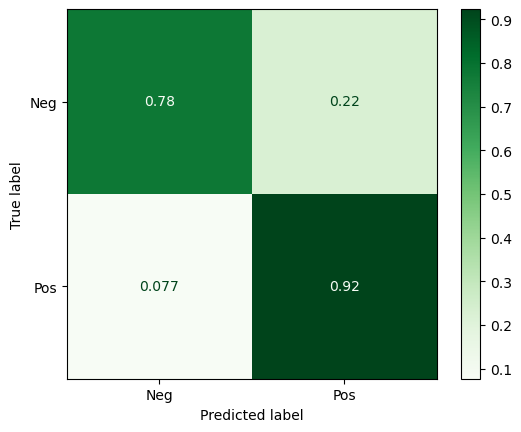

In [65]:
# fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    reviews,
    y,
    display_labels=['Neg', 'Pos'],
    cmap='Greens',
    normalize='true'
    # ax=ax
)
plt.show()

# Testowanie za pomocą walidacji krzyżowej z GridSearchCV

In [67]:
clf.named_steps

{'countvectorizer': CountVectorizer(binary=True, max_df=0.95, min_df=0.001, strip_accents='ascii'),
 'multinomialnb': MultinomialNB()}

In [74]:
cv = GridSearchCV(
    estimator=clf,
    param_grid={
        # 'countvectorizer__binary': [True, False],
        # 'multinomialnb__fit_prior': [True, False]
        'countvectorizer__max_df': [1.0, 0.95, 0.90, 0.85, 0.80]
    },
    refit=False,
    scoring=['accuracy', 'f1'],
    verbose=4
).fit(reviews, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END countvectorizer__max_df=1.0; accuracy: (test=0.826) f1: (test=0.875) total time=   0.8s
[CV 2/5] END countvectorizer__max_df=1.0; accuracy: (test=0.882) f1: (test=0.921) total time=   0.8s
[CV 3/5] END countvectorizer__max_df=1.0; accuracy: (test=0.871) f1: (test=0.915) total time=   0.8s
[CV 4/5] END countvectorizer__max_df=1.0; accuracy: (test=0.878) f1: (test=0.919) total time=   0.8s
[CV 5/5] END countvectorizer__max_df=1.0; accuracy: (test=0.857) f1: (test=0.902) total time=   0.8s
[CV 1/5] END countvectorizer__max_df=0.95; accuracy: (test=0.826) f1: (test=0.875) total time=   0.8s
[CV 2/5] END countvectorizer__max_df=0.95; accuracy: (test=0.882) f1: (test=0.921) total time=   0.8s
[CV 3/5] END countvectorizer__max_df=0.95; accuracy: (test=0.871) f1: (test=0.915) total time=   0.8s
[CV 4/5] END countvectorizer__max_df=0.95; accuracy: (test=0.878) f1: (test=0.919) total time=   0.8s
[CV 5/5] END countvectorize

In [75]:
cv.cv_results_

{'mean_fit_time': array([0.64472666, 0.6456233 , 0.65151072, 0.65585976, 0.66571059]),
 'std_fit_time': array([0.01817834, 0.01878963, 0.02248328, 0.02010787, 0.0229545 ]),
 'mean_score_time': array([0.14906054, 0.15063868, 0.15243602, 0.15258865, 0.15579996]),
 'std_score_time': array([0.01628559, 0.01621277, 0.0157    , 0.01675858, 0.01693847]),
 'param_countvectorizer__max_df': masked_array(data=[1.0, 0.95, 0.9, 0.85, 0.8],
              mask=[False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'countvectorizer__max_df': 1.0},
  {'countvectorizer__max_df': 0.95},
  {'countvectorizer__max_df': 0.9},
  {'countvectorizer__max_df': 0.85},
  {'countvectorizer__max_df': 0.8}],
 'split0_test_accuracy': array([0.82605514, 0.82605514, 0.82605514, 0.82605514, 0.82703098]),
 'split1_test_accuracy': array([0.88238165, 0.88238165, 0.88238165, 0.88238165, 0.88286969]),
 'split2_test_accuracy': array([0.87091264, 0.87091264, 0.87091264, 0.87091264, 0.87091264]),
 'split3_te

# Logistic Regression - Regresja Logistyczna (służy do klasyfikacji!!!)

In [127]:
clf = make_pipeline(CountVectorizer(input='content',
                                    strip_accents='ascii',
                                    lowercase=True,
                                    max_df=0.95,
                                    min_df=0.001,
                                    # ngram_range=(1, 2),
                                    binary=True),
                    LogisticRegression(penalty='l2', solver='liblinear', C=0.1))
clf.fit(rev_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, max_df=0.95, min_df=0.001,
                                 ngram_range=(1, 2), strip_accents='ascii')),
                ('logisticregression',
                 LogisticRegression(C=0.1, solver='liblinear'))])

In [128]:
y_pred_train = clf.predict(rev_train)
y_pred_test = clf.predict(rev_test)

print(f'Dokładność na danych uczących: {accuracy_score(y_train, y_pred_train) * 100:0.0f}%')
print(f'Dokładność na danych testowych: {accuracy_score(y_test, y_pred_test) * 100:0.0f}%')

Dokładność na danych uczących: 97%
Dokładność na danych testowych: 90%


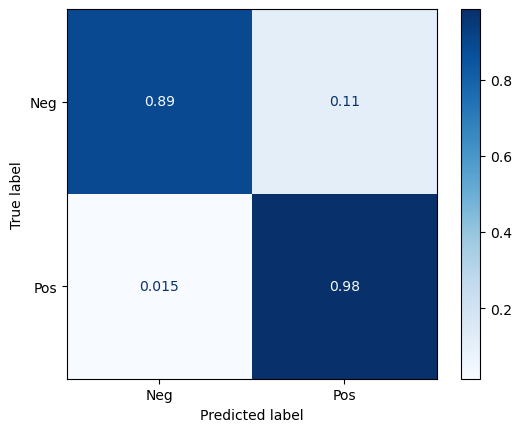

In [129]:
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    reviews,
    y,
    display_labels=['Neg', 'Pos'],
    cmap='Blues',
    normalize='true'
)
plt.show()

# Wykres dokładności w zależności od siły regularyzacji

In [94]:
cv = GridSearchCV(
    estimator=clf,
    param_grid={
        'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'logisticregression__penalty': ['l1']
    },
    refit=False,
    return_train_score=True,
    scoring=['accuracy'],
    verbose=4
).fit(reviews, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logisticregression__C=0.001, logisticregression__penalty=l1; accuracy: (train=0.737, test=0.737) total time=   0.9s
[CV 2/5] END logisticregression__C=0.001, logisticregression__penalty=l1; accuracy: (train=0.737, test=0.737) total time=   0.8s
[CV 3/5] END logisticregression__C=0.001, logisticregression__penalty=l1; accuracy: (train=0.737, test=0.737) total time=   0.9s
[CV 4/5] END logisticregression__C=0.001, logisticregression__penalty=l1; accuracy: (train=0.737, test=0.736) total time=   0.9s
[CV 5/5] END logisticregression__C=0.001, logisticregression__penalty=l1; accuracy: (train=0.737, test=0.736) total time=   0.9s
[CV 1/5] END logisticregression__C=0.01, logisticregression__penalty=l1; accuracy: (train=0.843, test=0.838) total time=   0.9s
[CV 2/5] END logisticregression__C=0.01, logisticregression__penalty=l1; accuracy: (train=0.842, test=0.842) total time=   0.9s
[CV 3/5] END logisticregression__C=0.01

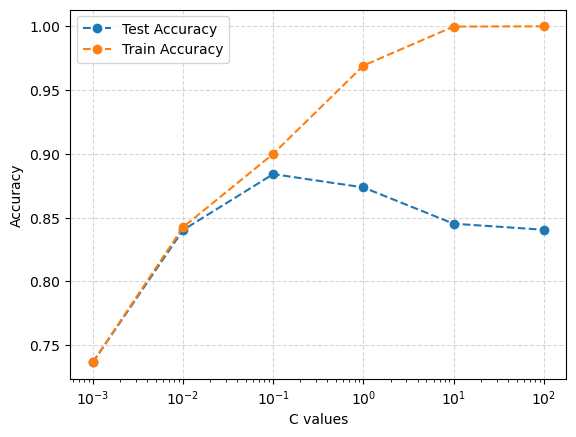

In [96]:
test_acc = cv.cv_results_['mean_test_accuracy']
train_acc = cv.cv_results_['mean_train_accuracy']
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

plt.plot(C_values, test_acc, marker='o', ls='--', label='Test Accuracy')
plt.plot(C_values, train_acc, marker='o', ls='--', label='Train Accuracy')
plt.legend()
plt.grid(alpha=0.5, ls='--')
plt.xscale('log')
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.show()

# Regularyzacja L1 i selekcja cech

In [135]:
clf = make_pipeline(CountVectorizer(input='content',
                                    strip_accents='ascii',
                                    lowercase=True,
                                    max_df=0.95,
                                    min_df=0.001,
                                    # ngram_range=(1, 2),
                                    binary=True),
                    LogisticRegression(penalty='l1', solver='liblinear', C=0.1))
clf.fit(rev_train, y_train)

y_pred_train = clf.predict(rev_train)
y_pred_test = clf.predict(rev_test)

print(f'Dokładność na danych uczących: {accuracy_score(y_train, y_pred_train) * 100:0.0f}%')
print(f'Dokładność na danych testowych: {accuracy_score(y_test, y_pred_test) * 100:0.0f}%')

n_all_weights = clf.named_steps['logisticregression'].coef_[0].shape[0]
n_non_zero_weights = np.sum(clf.named_steps['logisticregression'].coef_[0] != 0)
print(f'Liczba wag niezerowych: {n_non_zero_weights} z {n_all_weights}')

Dokładność na danych uczących: 91%
Dokładność na danych testowych: 89%
Liczba wag niezerowych: 500 z 16115


In [136]:
weights = clf.named_steps['logisticregression'].coef_[0]
print(f'Liczba cech: {weights.shape[0]}')
print(f'Cechy zerowe: {(weights == 0).sum()}')
print(f'Cechy negatywne (ujemne): {(weights < 0).sum()}')
print(f'Cechy pozytywne (dodatnie): {(weights > 0).sum()}')

Liczba cech: 16115
Cechy zerowe: 15615
Cechy negatywne (ujemne): 241
Cechy pozytywne (dodatnie): 259


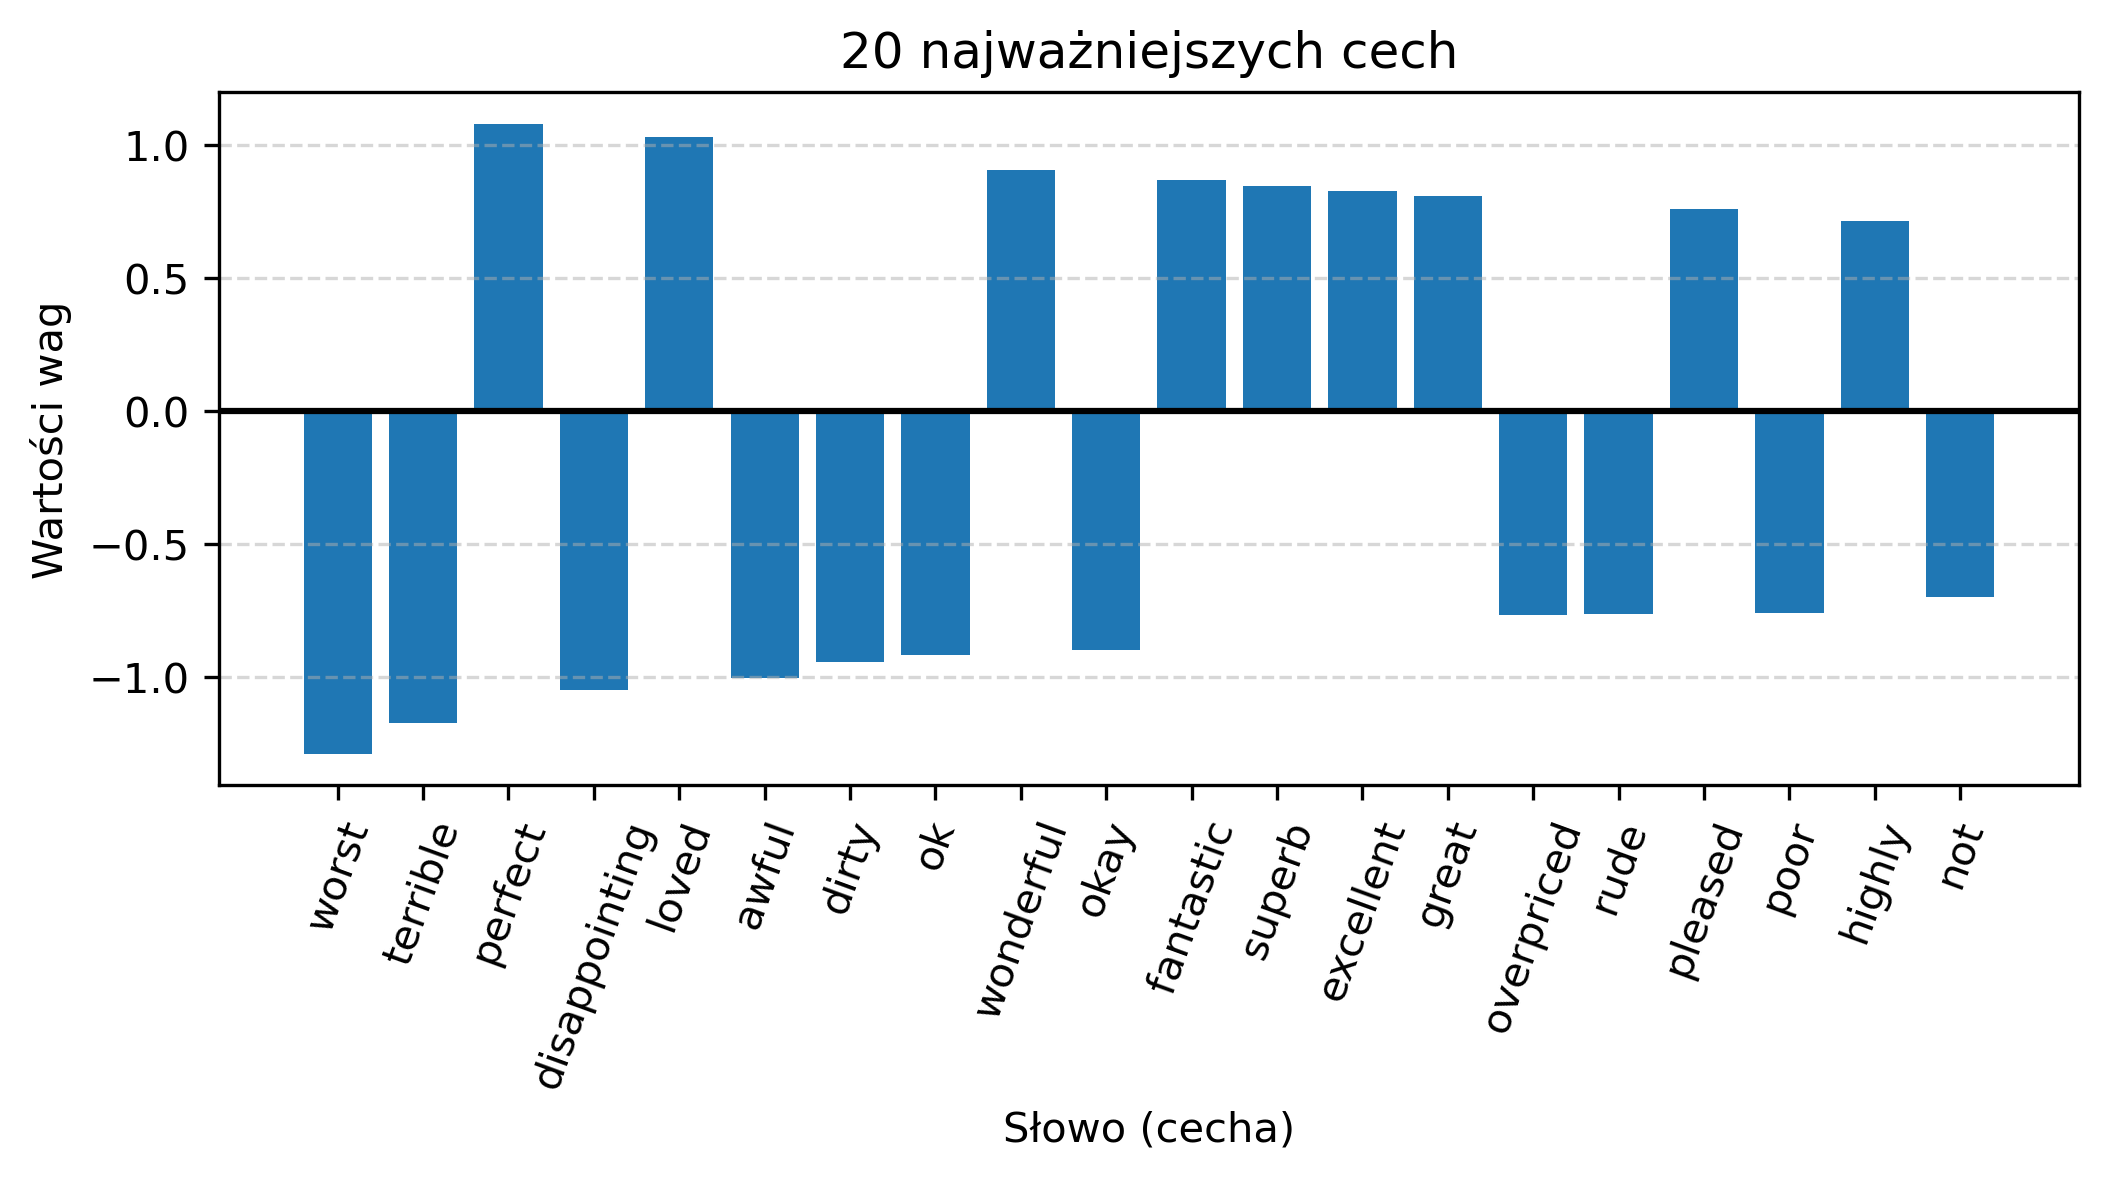

In [118]:
weights = clf.named_steps['logisticregression'].coef_[0]
words = clf.named_steps['countvectorizer'].get_feature_names_out()

n = 20
sort_indices = np.argsort(np.abs(weights))[::-1]

fig, ax = plt.subplots(figsize=(8, 3), dpi=300)

weights = weights[sort_indices][:n]
x = np.arange(n)
ax.bar(x, weights)
ax.axhline(0, c='k')

ax.grid(ls='--', alpha=0.5, axis='y')
ax.set_xticks(x)
ax.set_xticklabels(words[sort_indices][:n], rotation=70)
ax.set_ylabel('Wartości wag')
ax.set_xlabel('Słowo (cecha)')
ax.set_title(f'{n} najważniejszych cech')

plt.show()

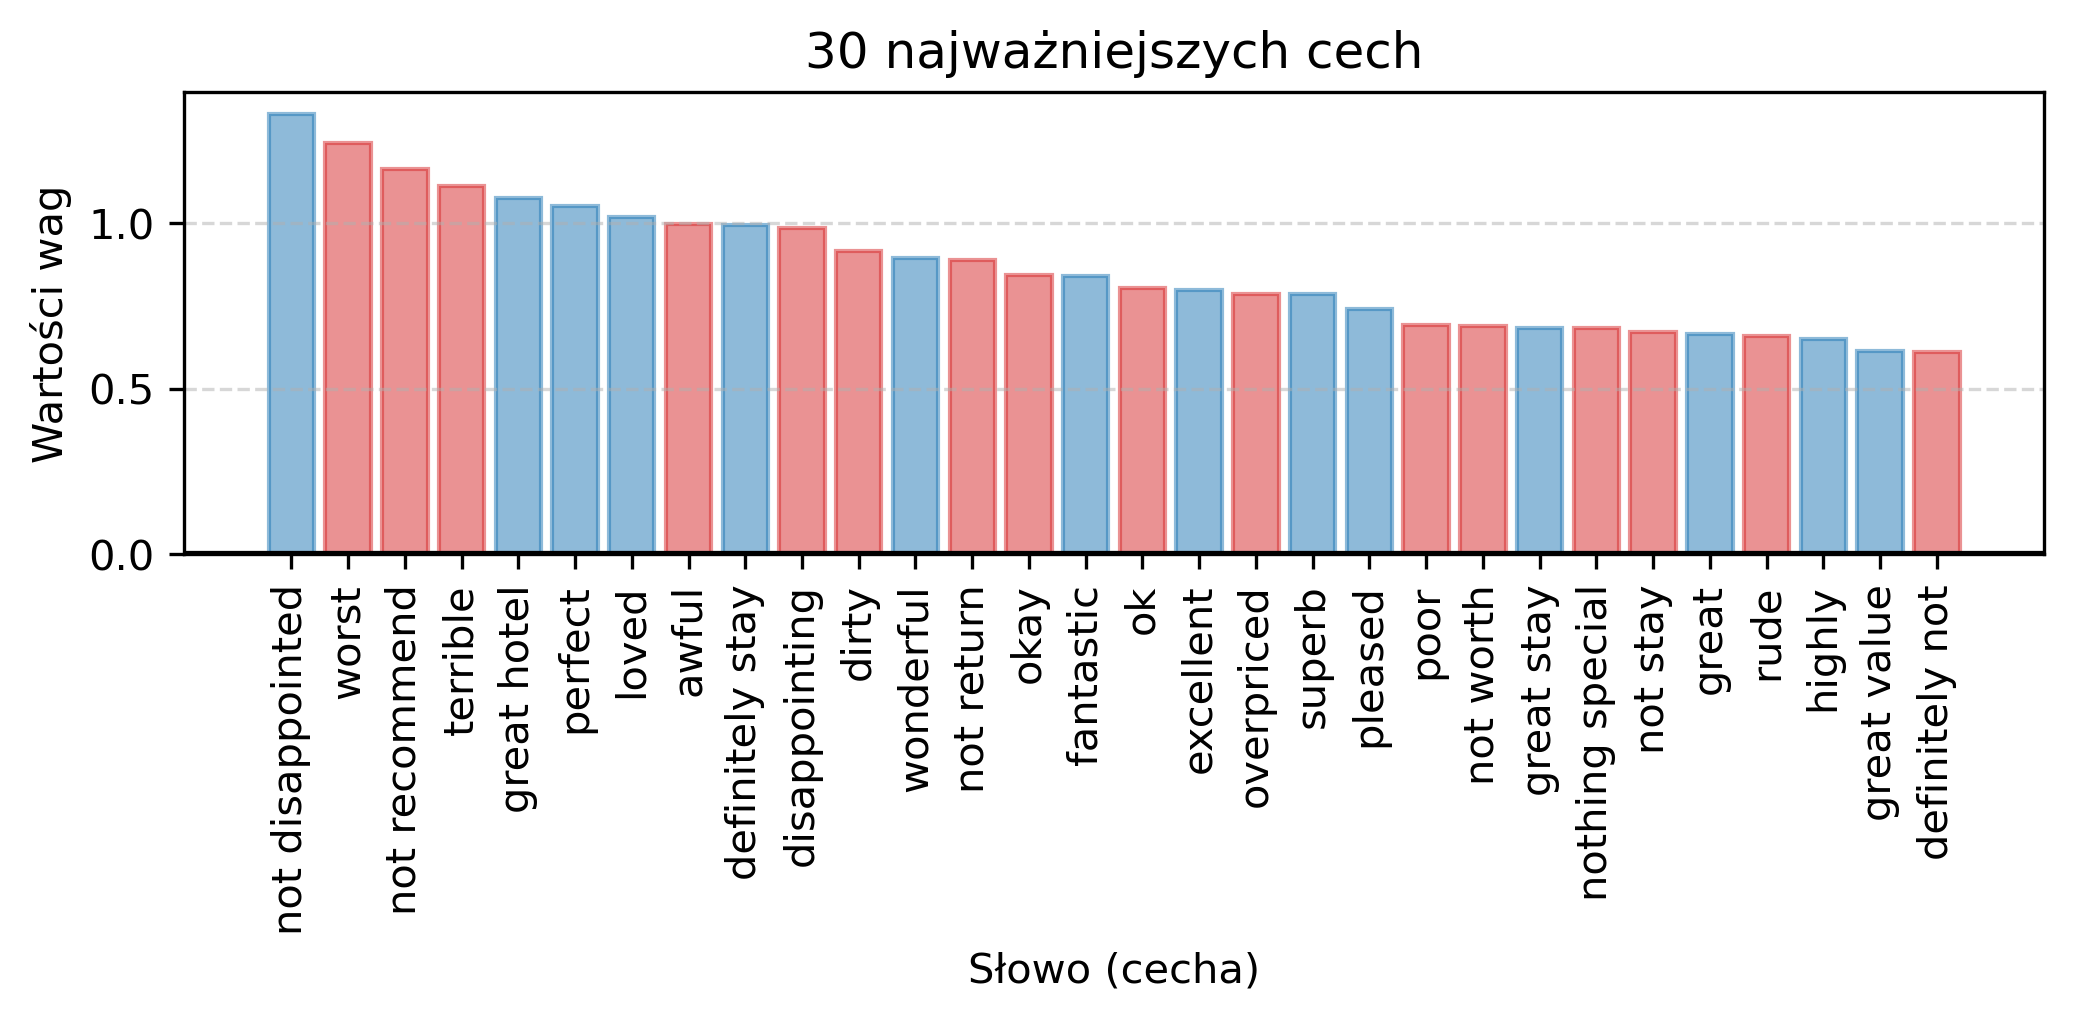

In [137]:
weights = clf.named_steps['logisticregression'].coef_[0]
words = clf.named_steps['countvectorizer'].get_feature_names_out()

n = 30
sort_indices = np.argsort(np.abs(weights))[::-1]

fig, ax = plt.subplots(figsize=(8, 2), dpi=300)

weights = weights[sort_indices][:n]
pos_indices = (weights > 0)
neg_indices = (weights <= 0)
x = np.arange(n)
ax.bar(x[pos_indices], np.abs(weights[pos_indices]), color='tab:blue', edgecolor='tab:blue', alpha=0.5)
ax.bar(x[neg_indices], np.abs(weights[neg_indices]), color='tab:red', edgecolor='tab:red', alpha=0.5)
ax.axhline(0, c='k')

ax.grid(ls='--', alpha=0.5, axis='y')
ax.set_xticks(x)
ax.set_xticklabels(words[sort_indices][:n], rotation=90)
ax.set_ylabel('Wartości wag')
ax.set_xlabel('Słowo (cecha)')
ax.set_title(f'{n} najważniejszych cech')

plt.show()

# Zadanie (praca własna)

1. Znaleźć na Kaggle dataset zawierający opinie/recenzje/teksty itd na którym można wykonać zadania klasyfikacji (najlepiej binarnej).
1. Za pomocą make_pipeline stworzyć dwa pipeliny z `CountVectorizer`, a następnie `MultinomialNB` oraz `LogisticRegression`. Dobrać
parametry do `CountVectorizer` tak, żeby odciąć najczęsciej oraz najrzadziej występujące słowa.
1. Dla obu modeli:
    - Nauczyć model na danych uczących.
    - Pokazać dokładność predykcji na danych uczących i na danych testowych.
    - Wygenerować macierz konfuzji dla obu klasyfikatorów (*: Zrobić tak, żeby obie macierzy były wygenerowane na jednym Figure (trzeba zrobić Figure z dwoma ax i sprawdzić w dokumentacji jak podać ax do funkcji generującej wykres macierzy konfuzji.))
    - Przetestować kilka różnych zestawów parametrów, potencjalnie zwiększając jakość modeli.
1. Dla regresji Logistycznej w regularyzacją L2: zastosować `GridSearchCV` do doboru optymalnej wartości C.
1. Stworzyć model Regresji Logistycznej używając regularyzacji L1.
1. Wygenerować wykres, przedstawiający wartości 20tu wag oraz cech dla tych wag, które najbardziej wpływają na odpowiedź modelu.